**Lets Embark on a journey to build your own Machine Translation Transfomer from Scratch**

- [ ] Positional Encoding
- [ ] Multi Head Attention
- [ ] Feed Forward Network
- [ ] Encoder Block
- [ ] Decoder Block
- [ ] Transformer
- [ ] Model Training

### Background
 RNNs/LSTMS inherently take the order of word into account; They parse a sentence word by word in a sequential manner which is why they are slow

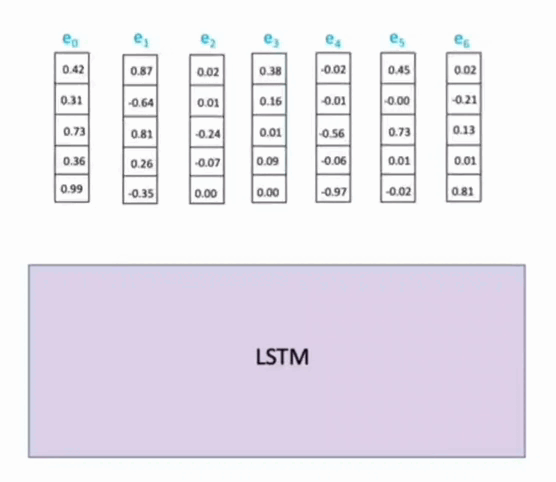

Tranformers on the other hand takes these embeddings simultaneously. But the question is:

 **How do Transformers preserve the sequential order of information within the input data?**
 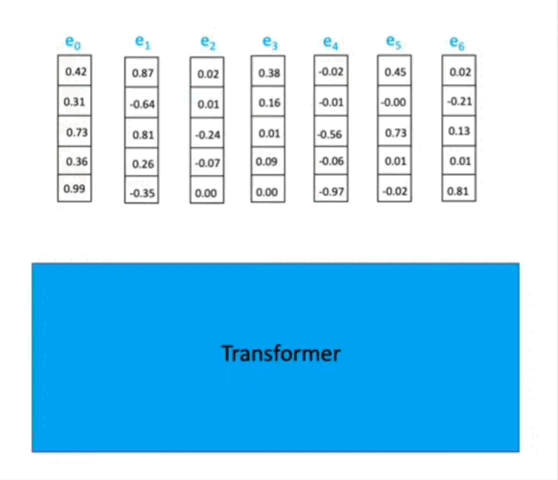

To make the transformers context aware, how about we introduce a new set of vectors containing the position information
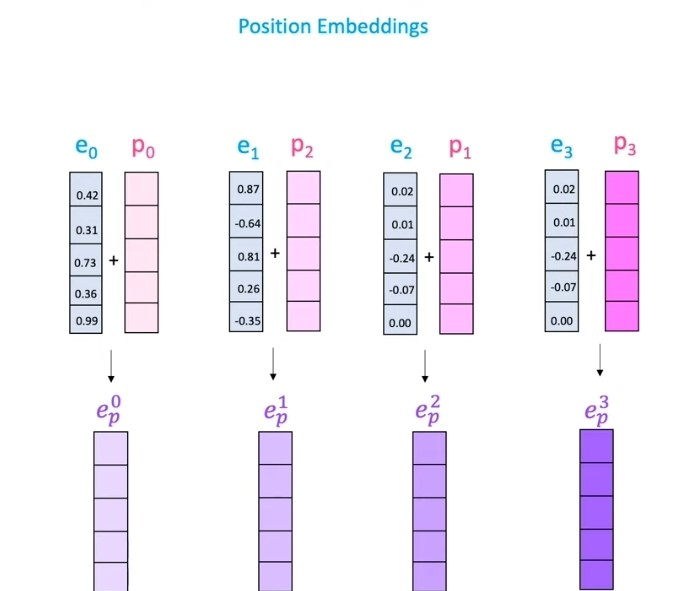

## **QUESTION!**
**What values should these position embeddings contain?**
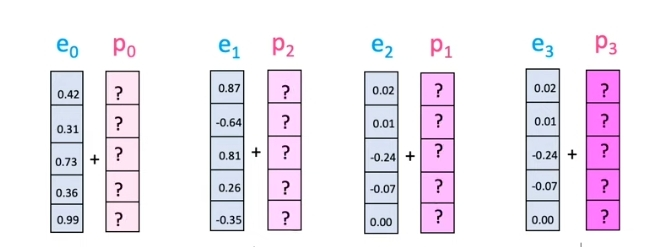

### **Solution!**
The Authors of the paper "[Attention is all you need](https://https://arxiv.org/pdf/1706.03762.pdf)" have proposed a very elegant solution for these position embeddings.

#### **Positional Encoding**: The positional encoding function in the transformers architecture introduces the concept of order or position into the input data.
The positional encoding function maps each position (or time step) in the input sequence to a vector representation. These positional embeddings are added element-wise to the input embeddings (usually word embeddings) before feeding them into the transformer model.

The most common type of positional encoding used is based on the **sine** and **cosine** functions. This method ensures that the positional embeddings have a consistent pattern, allowing the model to generalize well to longer sequences it might not have seen during training.
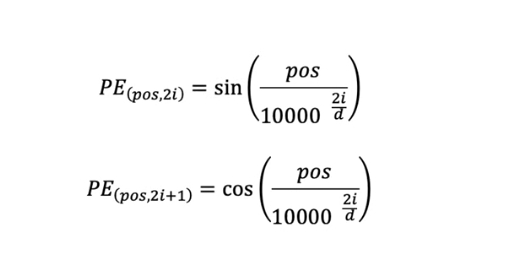

Where "pos" is the position and "i" is the dimension. "d_model" is the dimension of the embedding vector.

## Implementation of Positional Encoding

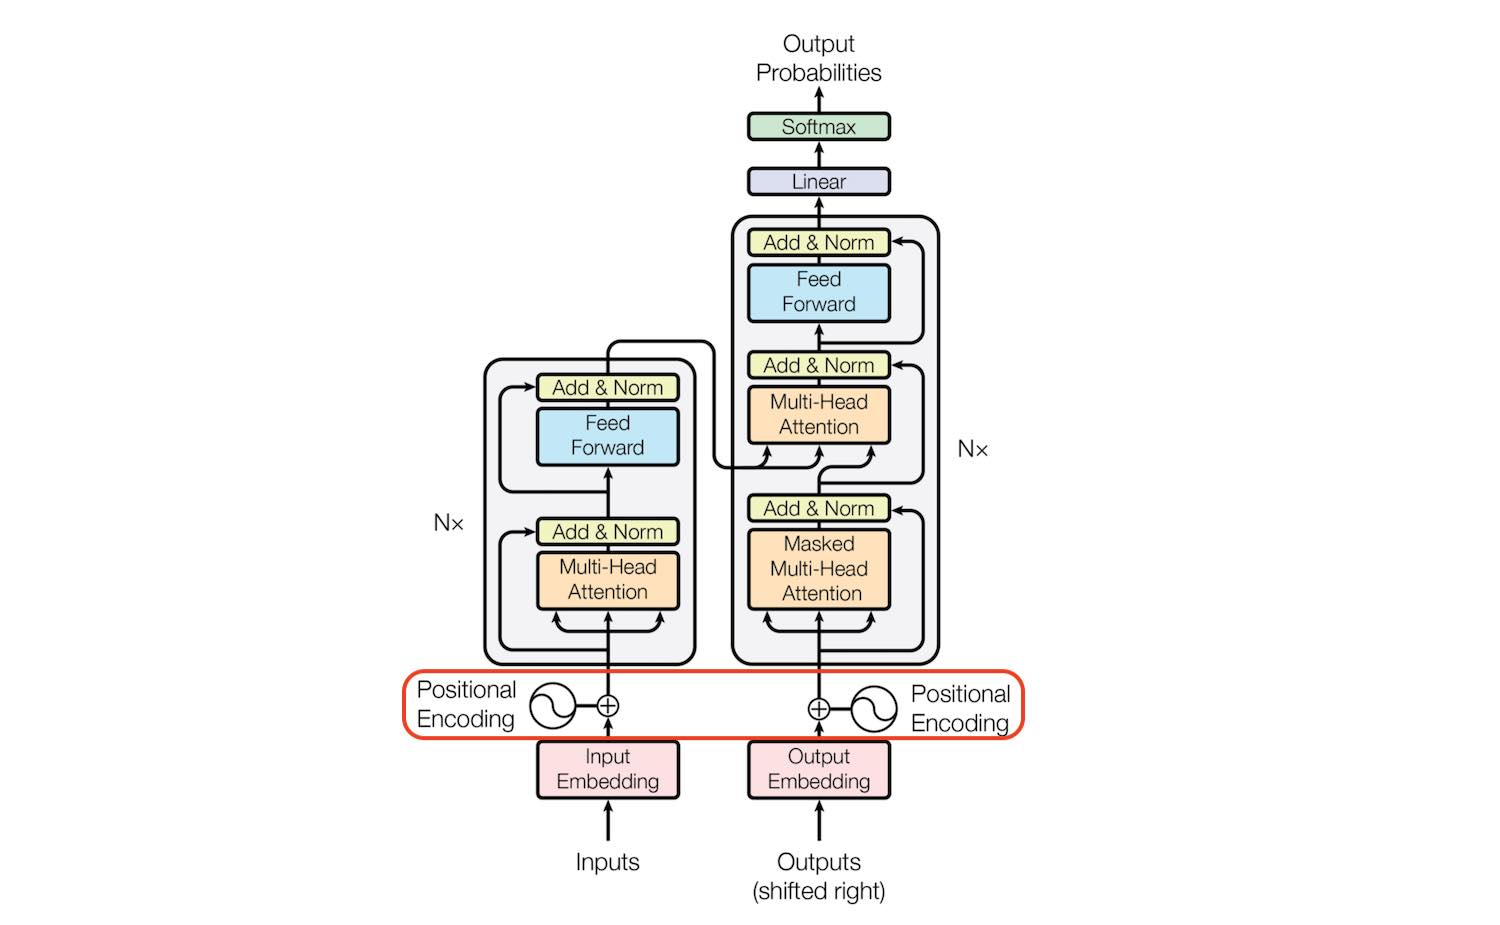

Header Photo by [Susan Yin](https://https://unsplash.com/@syinq?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://https://unsplash.com/s/photos/library?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)

In [ ]:
import numpy as np
import tensorflow as tf

#

def positional_encoding(seq_len, d_model):
   # Create an array with sequential positions and introduce a new axis
    position = np.arange(seq_len)[:, np.newaxis]
    # print("Position array:")
    # print(position)

    #represents a set of values that determine how the positional encodings are scaled and calculated.
    div_term = np.arange(0, d_model, 2, dtype=np.float32) / d_model
    # print("div_term calculation:")
    # print(div_term)

    div_term = 1 / (np.power(10000, div_term))
    # print("Final div_term:")
    # print(div_term)

    pos_enc = np.zeros((seq_len, d_model))
    # print("Initialized pos_enc array:")
    # print(pos_enc)

    sin_part = np.sin(position * div_term)
    cos_part = np.cos(position * div_term)

    # print("sin_part (for even dimensions):")
    # print(sin_part)
    # print("cos_part (for odd dimensions):")
    # print(cos_part)

    # Assign sine components to even dimensions and cosine components to odd dimensions
    pos_enc[:, 0::2] = sin_part
    pos_enc[:, 1::2] = cos_part
    return tf.cast(pos_enc, dtype=tf.float32)
# Define the sequence length and embedding dimension
seq_len = 8
d_model = 4

# Calculate positional encodings for your sequence
pos_encodings = positional_encoding(seq_len, d_model)
print("Positional Encodings:")
print(pos_encodings)

Positional Encodings:
tf.Tensor(
[[ 0.          1.          0.          1.        ]
 [ 0.84147096  0.5403023   0.00999983  0.99995   ]
 [ 0.9092974  -0.41614684  0.01999867  0.9998    ]
 [ 0.14112    -0.9899925   0.0299955   0.99955004]
 [-0.7568025  -0.6536436   0.03998933  0.9992001 ]
 [-0.9589243   0.2836622   0.04997917  0.99875027]
 [-0.2794155   0.96017027  0.059964    0.99820054]
 [ 0.6569866   0.75390226  0.06994285  0.997551  ]], shape=(8, 4), dtype=float32)


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    A positional embedding layer combines the input embedding with a positional encoding that helps the Transformer
    to understand the relative position of the input tokens. This layer takes the input of tokens and converts them
    into sequence of embeddings vector. Then, it adds the positional encoding to the embeddings.

    Methods:
        compute_mask: Computes the mask to be applied to the embeddings.
        call: Performs the forward pass of the layer.
    """
    def __init__(self, vocab_size: int, d_model: int, embedding: tf.keras.layers.Embedding=None):
        """ Constructor of the PositionalEmbedding layer.

        Args:
            vocab_size (int): The size of the vocabulary. I. e. the number of unique tokens in the input sequence.
            d_model (int): The dimensionality of the embedding vector.
            embedding (tf.keras.layers.Embedding): The custom embedding layer. If None, a default embedding layer will be created.
        """
        super().__init__()
        self.d_model = d_model
        #This line creates an embedding layer. If the embedding argument is not provided (i.e., None), it creates a default embedding layer using tf.keras.layers.Embedding.
        # This layer is responsible for converting input tokens into embedding vectors.
        #The mask_zero=True argument indicates that tokens with a value of 0 should be treated as padding and masked during computations.
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) if embedding is None else embedding
        self.pos_encoding = positional_encoding(2048, d_model)

    def compute_mask(self, *args, **kwargs):
        """ Computes the mask to be applied to the embeddings.
        This method allows the layer to compute a mask to be applied to the embeddings.
        It delegates the mask computation to the underlying embedding layer, which is useful when handling variable-length sequences and masking padding tokens.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """ Performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input tensor of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of embedding vectors with added positional information. The shape is
                (batch_size, seq_length, d_model).
        """
       # Pass the input tokens through the embedding layer to get embedding vectors.
        x = self.embedding(x)

      # Calculate the length of the input sequence.
        length = tf.shape(x)[1]

      # Scale the embedding vectors to ensure compatibility with positional encodings.
      # The square root of the dimension (d_model) is used to adjust the scale.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

      # Add the positional encodings to the scaled embeddings.
      # This step combines the token embeddings with positional information.
        x = x + self.pos_encoding[tf.newaxis, :length, :]

        return x

In [ ]:
vocab_size = 1000
d_model = 512

embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_input = np.random.randint(0, vocab_size, size=(1, 100))

output = embedding_layer(random_input)
print("random_input shape", random_input.shape)
print("PositionalEmbedding output", output.shape)

random_input shape (1, 100)
PositionalEmbedding output (1, 100, 512)


# Attentions


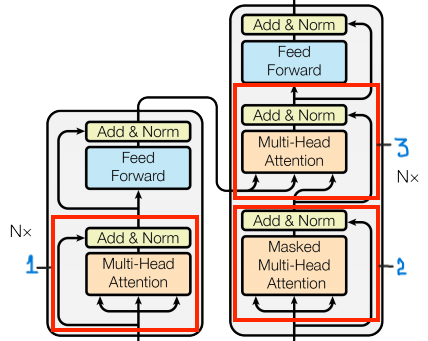

In this image there are three attention blocks as labelled in the figure


1.   Global Self Attention Layer
2.   Causal Self Attention Layer
3.   Cross Attention Layer

All three attention layers have three things in common:


*   Multi-Head Attention
*   Add layer which is responsible for residual connection
*   Normalization layer

Therefore, we will first implement the **base attention layer**, and which will be subsequently employed by each of the attention blocks.






### The Base Attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()  # Initialize the parent class (tf.keras.layers.Layer)

        # Create a Multi-Head Attention layer with optional keyword arguments
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)

        # Create a Layer Normalization layer
        self.layernorm = tf.keras.layers.LayerNormalization()

        # Create an Add layer, which implements the residual connection
        self.add = tf.keras.layers.Add()


### The Global Self Attention Layer
<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Lets work on the blueprint before jumping into the code:
1. We'll utilize the base attention layer and implement our forward function.
2. The input "x" would go in as query, key, value for multi-head attention.
3. The Add Layer would take two arguments: the input "x" and the output of multi-head attention.
4. The normalization layer will take the input "x".

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    """
        The call function that performs the global self-attention operation.

        Args:
            x : The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            x : The output sequence of shape (batch_size, seq_length, d_model).
        """
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Lets test the class

In [ ]:
vocab_size = 1000
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

global_self_attention_layer = GlobalSelfAttention(num_heads=2, key_dim=512)
global_self_attention_output = global_self_attention_layer(encoder_embeddings)

print("global_self_attention_output shape", global_self_attention_output.shape)

encoder_embeddings shape (1, 100, 512)
global_self_attention_output shape (1, 100, 512)


### The Cross Attention Layer
<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

Lets work on the blueprint before jumping into the code:
1. We'll utilize the base attention layer and implement our forward function.
2. Muti head attention will take the key and value from the encoder (refered in the code as "context"). Query vectors will be taken from the decoder (refered in the code as "x").
3. The Add Layer would take two arguments: the input "x" and the output of multi-head attention.
4. The normalization layer will take the input "x".

The **Implementation** of this layer is a **Task** for you.

Time alloted: **5 minutes**

All the hints are given and discussed.

Buck up! you can do this.. 😎

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test the cross attention class

In [ ]:
vocab_size = 1000
encoder_vocab_size = 1000
decoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)
decoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))
random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)
decoder_embeddings = decoder_embedding_layer(random_decoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)
print("decoder_embeddings shape", decoder_embeddings.shape)

cross_attention_layer = CrossAttention(num_heads=2, key_dim=512)
cross_attention_output = cross_attention_layer(decoder_embeddings, encoder_embeddings)

print("cross_attention_output shape", cross_attention_output.shape)

encoder_embeddings shape (1, 100, 512)
decoder_embeddings shape (1, 110, 512)
cross_attention_output shape (1, 110, 512)


### The Causal Self Attention Layer
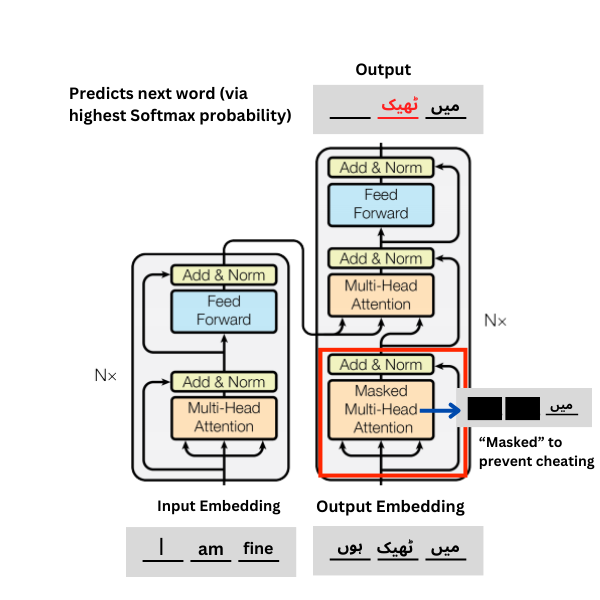

Before writing our code, lets contemplate on the masked/causal multi head attention for a minute.

**Point to ponder**: Why are we masking the subsequent tokens?

**Hint**: Common sense :p

The **Implementation** of this layer is a **Task** for you.

Time alloted: **5 minutes**

The only guidance you require for the implementation is: " Utilize the parameter **use_causal_mask = True** when configuring the Multi-Head Attention (mha) mechanism."

This is the last of Attention block in the Transformer architecture... 😎

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Test the layer

In [ ]:
decoder_vocab_size = 1000
d_model = 512

decoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

decoder_embeddings = decoder_embedding_layer(random_decoder_input)

print("decoder_embeddings shape", decoder_embeddings.shape)

causal_self_attention_layer = CausalSelfAttention(num_heads=2, key_dim=512)
causal_self_attention_output = causal_self_attention_layer(decoder_embeddings)

print("causal_self_attention_output shape", causal_self_attention_output.shape)

decoder_embeddings shape (1, 110, 512)
causal_self_attention_output shape (1, 110, 512)


### The Feed Forward Network

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The following paragraph is taken from the paper "Attention is all you need".


In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
dff = 2048.

So from the paragraphs we can deduce the steps require for implementation of feed forward network:

1. Initialize 2- fully connected dense layers and a dropout layer.
2. Apply ReLU activation function.
3. Specify the argument d_model and dff (The dimensionality of the feed-forward layer.)
4. Taking a look at the picture, we have to apply Add & norm in the foward function.

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

Test the Feed Forward Network

In [ ]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

feed_forward_layer = FeedForward(d_model, dff=2048)
feed_forward_output = feed_forward_layer(encoder_embeddings)

print("feed_forward_output shape", feed_forward_output.shape)

encoder_embeddings shape (1, 100, 512)
feed_forward_output shape (1, 100, 512)


**"Halfway through the Transformer, keep coding, the best is yet to come!" 🚀🌟**

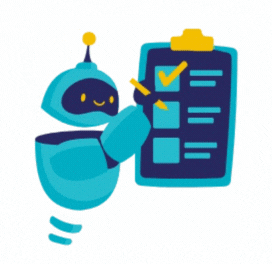


Lets take a look at our check list:
- [x] Positional Encoding
- [x] Multi Head Attention
- [x] Feed Forward Network
- [ ] Encoder Block
- [ ] Decoder Block
- [ ] Transformer
- [ ] Model Training


### The Encoder Layer
<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Lets see how can we implement the encoder layer:

1. Create the instance of GlobalSelfAttention.
2. The parameters of GlobalSelfAttention will be num_heads,key_dim,dropout_rate. If you are confused, refer to the notebook where we implemented Multi Head Attention from scratch.
3. Create the instance of FeedFoward with parameters d_model, dff.
4. Write a forward layer function "call", pass the sequence x through attention , and feedforward variable instances.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

Test the encoder layer


In [ ]:
encoder_vocab_size = 1000
d_model = 512

encoder_embedding_layer = PositionalEmbedding(vocab_size, d_model)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_embeddings = encoder_embedding_layer(random_encoder_input)

print("encoder_embeddings shape", encoder_embeddings.shape)

encoder_layer = EncoderLayer(d_model, num_heads=2, dff=2048)

encoder_layer_output = encoder_layer(encoder_embeddings)

print("encoder_layer_output shape", encoder_layer_output.shape)

encoder_embeddings shape (1, 100, 512)
encoder_layer_output shape (1, 100, 512)


### The Encoder

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

Lets Join the pieces to build our encoder block:

1. Create the instance of Positional Encoding, it requires two parameters: vocab_size, and d_model.
2. Create the instance of EncoderLayer

**Hold on**: There should be "n" number of encoder layers, right?

~Absolutely right! We will need to create multiple instances of encoderlayers.

3. Updating point 2: Create a list of EncoderLayer which will have n "num_layer"
4. The parameters of EncoderLayer will include: num_layers, d_model, num_heads,
dff, vocab_size, dropout_rate
5. Add a dropout layer
6. Create a forward function "call", which will pass the 'x' through Positional Encoding, Dropout, then through a loop of EncoderLayer instance variables.


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` ics token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Lets test the Encoder

In [ ]:
encoder_vocab_size = 1000
d_model = 512

encoder = Encoder(num_layers=2, d_model=d_model, num_heads=2, dff=2048, vocab_size=encoder_vocab_size)

random_encoder_input = np.random.randint(0, encoder_vocab_size, size=(1, 100))

encoder_output = encoder(random_encoder_input)

# Print the number of encoder layers
print("Number of encoder layers:", encoder.num_layers)

print("random_encoder_input shape", random_encoder_input.shape)
print("encoder_output shape", encoder_output.shape)

Number of encoder layers: 2
random_encoder_input shape (1, 100)
encoder_output shape (1, 100, 512)


### The Decoder Layer
<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

Lets pace up, and discuss the steps for decoder layer.

1. Create Instance for Causal Attention Layer with parameters: d_model,num_heads, dropout_rate.
2. Create Instance for Cross Attention Layer with parameters: d_model,num_heads,dropout_rate.
3. Create instance of Feed Forward with parameters: d_model,dff
4. Create a foward function "call", that will pass x through both the attentions and feed forward.
5. Context from encoder will also be passed through cross attention layer.  


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer

In [ ]:
# Test DecoderLayer layer
decoder_vocab_size = 1000
d_model = 512
dff = 2048
num_heads = 8

decoder_layer = DecoderLayer(d_model, num_heads, dff)

random_decoderLayer_input = np.random.randint(0, decoder_vocab_size, size=(1, 110))

decoder_embeddings = encoder_embedding_layer(random_decoderLayer_input)

decoderLayer_output = decoder_layer(decoder_embeddings, encoder_output)

print("random_decoder_input shape", random_decoderLayer_input.shape)
print("decoder_embeddings shape", decoder_embeddings.shape)
print("decoder_output shape", decoderLayer_output.shape)

random_decoder_input shape (1, 110)
decoder_embeddings shape (1, 110, 512)
decoder_output shape (1, 110, 512)


### The Decoder Block

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

At this stage you are expected to deduce the steps for implementing the decoder block.

It's time for **"The Task"**

Alloted time: **5 minutes**

Take guidance from encoder block! ;)

Hurry Up! You are almost there..

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    #for visualization purpose
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder block

In [ ]:
# Test decoder layer
decoder_vocab_size = 1000
d_model = 512

decoder_layer = Decoder(num_layers=2, d_model=d_model, num_heads=2, dff=2048, vocab_size=decoder_vocab_size)

random_decoder_input = np.random.randint(0, decoder_vocab_size, size=(1, 100))

decoder_output = decoder_layer(random_decoder_input, encoder_output)

print("random_decoder_input shape", random_decoder_input.shape)
print("decoder_output shape", decoder_output.shape)

random_decoder_input shape (1, 100)
decoder_output shape (1, 100, 512)


**Hey! You are almost there..** ✌


Lets take a look at the check list:
- [x] Positional Encoding
- [x] Multi Head Attention
- [x] Feed Forward Network
- [x] Encoder Block
- [x] Decoder Block
- [ ] Transformer
- [ ] Model Training

## The Transformer

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

**Welldone!**

**You did it..** 🏅


Lets Train our model!


In [ ]:
!pip install tensorflow tensorflow-datasets


Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

### Load Dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [ ]:
# examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
#                                with_info=True,
#                                as_supervised=True)

# train_examples, val_examples = examples['train'], examples['validation']

# Load the TED Talks translation dataset
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

# Split the dataset into training and validation sets
train_examples, val_examples = examples['train'], examples['validation']

# Set the desired size for the reduced dataset
desired_size = 10000

# Randomly sample 10,000 examples for training
train_examples = train_examples.shuffle(desired_size, reshuffle_each_iteration=False)
train_examples = train_examples.take(desired_size)

# Randomly sample 10,000 examples for validation
val_examples = val_examples.shuffle(desired_size, reshuffle_each_iteration=False)
val_examples = val_examples.take(desired_size)

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Tokenization

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format.

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The tokenize method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [ ]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

The lower level `lookup` method converts from token-IDs to token text:

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

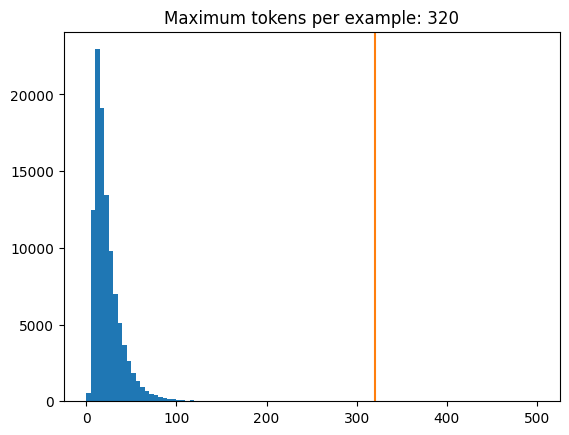

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.

In [ ]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training.

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples.
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 60)
(64, 64)
(64, 64)


In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2 115   9  55 102 315 110  93  99 165], shape=(10,), dtype=int64)
tf.Tensor([115   9  55 102 315 110  93  99 165 354], shape=(10,), dtype=int64)


### **Hyperparameters**

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

Instantiate the `Transformer` model:

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 64)
(64, 60)
(64, 64, 7010)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 64, 60)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_30 (Dense)            multiple                  904290    
                                                                 
Total params: 10184162 (38.85 MB)
Trainable params: 10184162 (38.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

It's time to prepare the model and start training it.

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

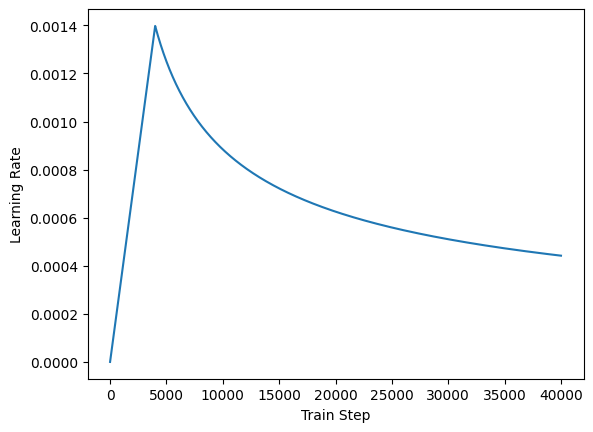

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:
Note: Be mindful then choosing number of epochs!

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=5,
                validation_data=val_batches)

Epoch 1/5
810/810 [==============================] - 277s 299ms/step - loss: 6.5965 - masked_accuracy: 0.1373 - val_loss: 5.0211 - val_masked_accuracy: 0.2520
Epoch 2/5
810/810 [==============================] - 206s 254ms/step - loss: 4.5601 - masked_accuracy: 0.2992 - val_loss: 4.0223 - val_masked_accuracy: 0.3620
Epoch 3/5
810/810 [==============================] - 202s 249ms/step - loss: 3.8173 - masked_accuracy: 0.3801 - val_loss: 3.6191 - val_masked_accuracy: 0.4018
Epoch 4/5
810/810 [==============================] - 202s 249ms/step - loss: 3.2920 - masked_accuracy: 0.4367 - val_loss: 3.0051 - val_masked_accuracy: 0.4857
Epoch 5/5
810/810 [==============================] - 202s 248ms/step - loss: 2.8977 - masked_accuracy: 0.4816 - val_loss: 2.8243 - val_masked_accuracy: 0.5034


### Inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book that i did .
Ground truth   : this is the first book i've ever done.


### Attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

Create a function that plots the attention when a token is generated:

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([10, 11])

These are the input (Portuguese) tokens:

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [ ]:
translated_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'that',
       b'i', b'did', b'.', b'[END]'], dtype=object)>

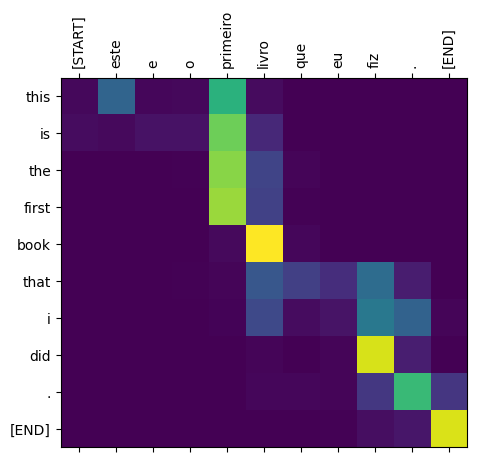

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

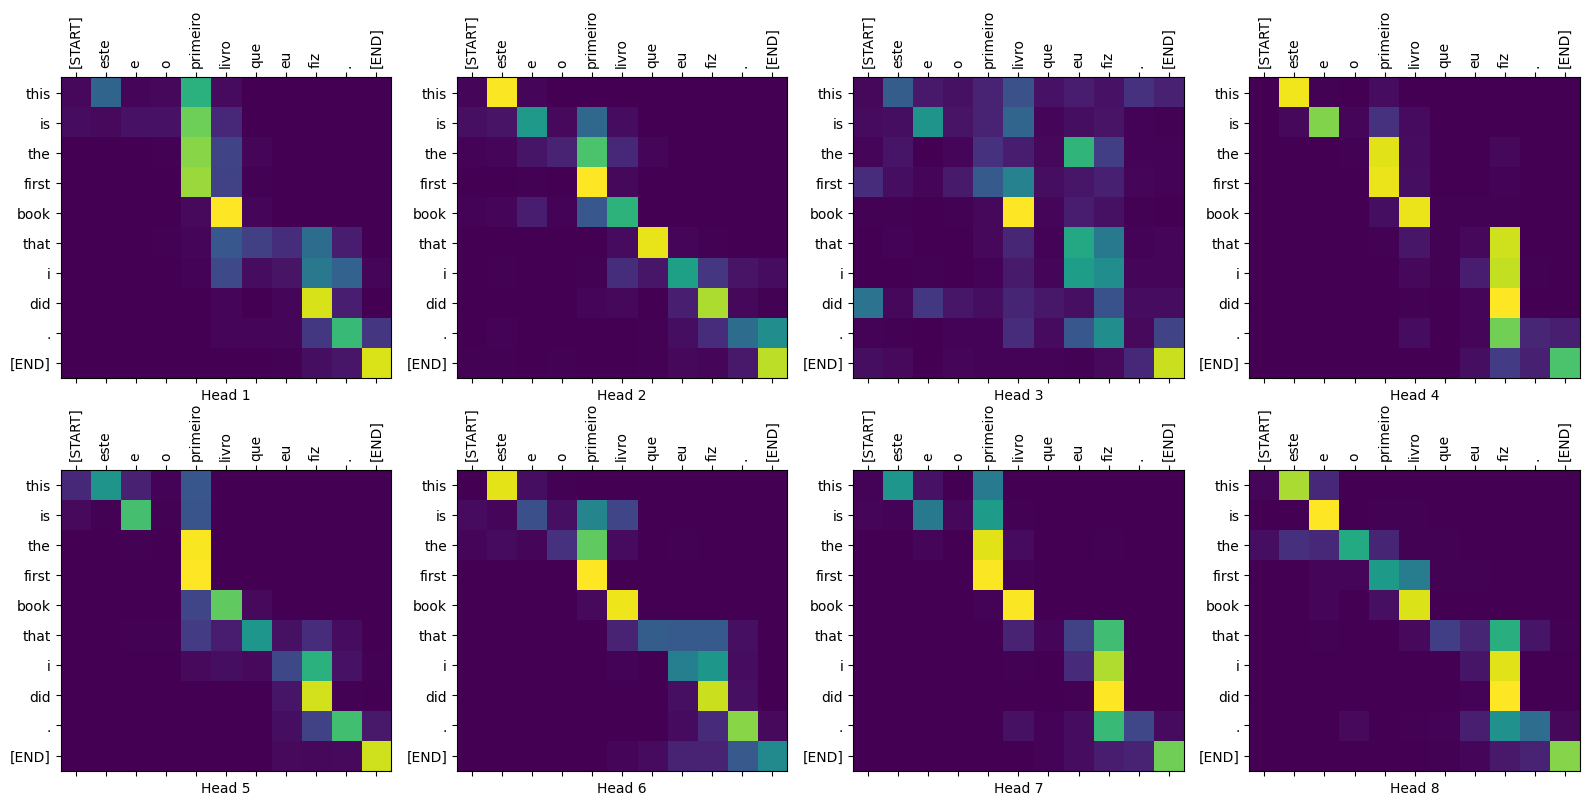

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

### **Reference Links**


https://www.youtube.com/watch?v=dichIcUZfOw

https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

https://pylessons.com/transformers-introduction

https://www.youtube.com/watch?v=mMa2PmYJlCo&list=PL86uXYUJ7999zE8u2-97i4KG_2Zpufkfb&pp=iAQB

https://jalammar.github.io/illustrated-transformer/

https://www.tensorflow.org/text/tutorials/transformer

https://arxiv.org/pdf/1706.03762.pdf